<a href="https://colab.research.google.com/github/wesleykieu/machine-learning-portfolio/blob/main/Credit_Fraud_Detection_6_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
import pandas as pd
import numpy as np

# ============================================
# DATA VISUALIZATION
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns

# For better plot styling
plt.style.use('seaborn-v0_8-darkgrid')  # or 'ggplot', 'fivethirtyeight'
sns.set_palette("husl")

# ============================================
# DATA PREPROCESSING
# ============================================
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample

# Handling imbalanced data
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# ============================================
# MODEL 1: LOGISTIC REGRESSION
# ============================================
from sklearn.linear_model import LogisticRegression

# ============================================
# MODEL 2: RANDOM FOREST
# ============================================
from sklearn.ensemble import RandomForestClassifier

# ============================================
# MODEL 3: GRADIENT BOOSTING (XGBoost/LightGBM)
# ============================================
import xgboost as xgb
from xgboost import XGBClassifier

# Alternative: LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

# ============================================
# MODEL 4: NEURAL NETWORK
# ============================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Alternative: PyTorch
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# ============================================
# MODEL 5: ANOMALY DETECTION
# ============================================
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Alternative: SVM for supervised learning
from sklearn.svm import SVC

# ============================================
# HYPERPARAMETER TUNING
# ============================================
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# ============================================
# EVALUATION METRICS
# ============================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    auc,
    matthews_corrcoef
)

# For plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ============================================
# FEATURE IMPORTANCE & ANALYSIS
# ============================================
from sklearn.inspection import permutation_importance

# ============================================
# STATISTICAL TESTS
# ============================================
from scipy import stats
from scipy.stats import ks_2samp

# ============================================
# UTILITIES
# ============================================
import warnings
warnings.filterwarnings('ignore')

# For saving models
import pickle
import joblib

# For timing
import time
from datetime import datetime

# For reproducibility
import random

In [ ]:
df = pd.read_csv(path + "/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


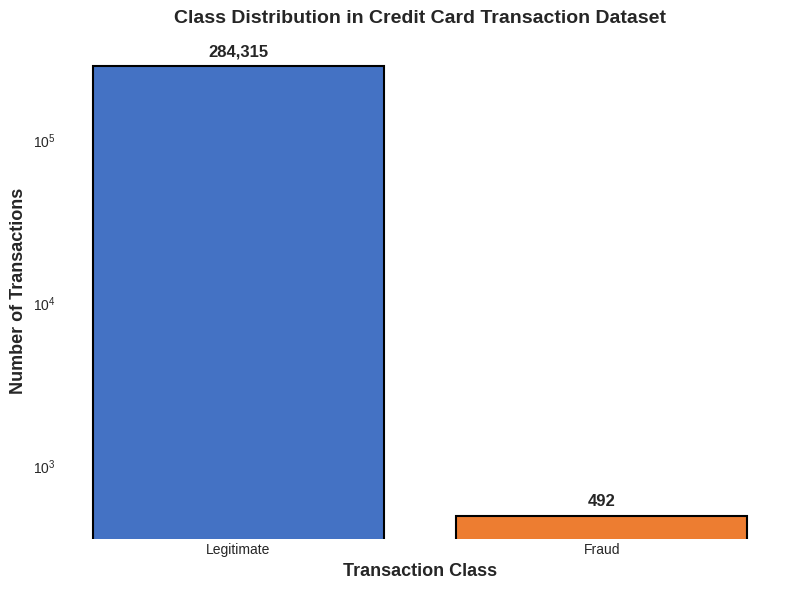

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

legitimate = 284315
fraud = 492

fig, ax = plt.subplots(figsize=(8, 6))

# Professional IEEE paper colors (colorblind-safe, grayscale-friendly)
bars = ax.bar(['Legitimate', 'Fraud'], [legitimate, fraud],
              color=['#4472C4', '#ED7D31'],  # Professional blue and orange
              edgecolor='black', linewidth=1.5)

ax.set_ylabel('Number of Transactions', fontsize=13, fontweight='bold')
ax.set_xlabel('Transaction Class', fontsize=13, fontweight='bold')
ax.set_title('Class Distribution in Credit Card Transaction Dataset',
             fontsize=14, fontweight='bold', pad=15)
ax.set_yscale('log')  # Log scale to show both classes clearly

# Add count labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height * 1.1,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.grid(axis='y', alpha=0.3, linestyle='--', which='both')
ax.set_facecolor('white')  # Clean white background for papers
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig('class_distribution_log.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Data Preprocessing

In [ ]:
# scale time and amount
scaler = StandardScaler()

df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

In [ ]:
# Target values and Features
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
# Split data 70-15-15

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
)

In [ ]:
log_reg = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42648
           1       0.06      0.89      0.12        74

    accuracy                           0.98     42722
   macro avg       0.53      0.93      0.55     42722
weighted avg       1.00      0.98      0.99     42722



In [ ]:


# ===== MODEL 3:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': ['balanced'],
    'max_iter': [1000]
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='f1',            # Optimize for F1 score
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


grid_search.fit(X_train, y_train)
log_reg_tuned = grid_search.best_estimator_

print("\n" + "="*50)
print("TUNED LOGISTIC REGRESSION (SMOTE + GridSearch)")
print("="*50)
print(f"Best parameters: {grid_search.best_params_}")

y_pred_tuned = log_reg_tuned.predict(X_test)
y_proba_tuned = log_reg_tuned.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_tuned, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

TUNED LOGISTIC REGRESSION (SMOTE + GridSearch)
Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     42648
       Fraud       0.07      0.89      0.13        74

    accuracy                           0.98     42722
   macro avg       0.53      0.94      0.56     42722
weighted avg       1.00      0.98      0.99     42722

ROC-AUC: 0.9647


In [ ]:
# ========== SMOTE OVERSAMPLING ==========
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# ========== LOGISTIC REGRESSION (NO TUNING) ==========
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

log_reg.fit(X_train_sm, y_train_sm)

# ========== EVALUATION ==========
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("LOGISTIC REGRESSION (SMOTE, No Tuning)")
print("="*50)

print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


LOGISTIC REGRESSION (SMOTE, No Tuning)
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     42648
       Fraud       0.06      0.88      0.11        74

    accuracy                           0.98     42722
   macro avg       0.53      0.93      0.55     42722
weighted avg       1.00      0.98      0.99     42722

ROC-AUC: 0.9617


## RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Base model
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# VERY small grid — only a few values
param_grid = {
    'n_estimators': [100, 200],     # small range
    'max_depth': [10, 20, None],    # shallow vs deep
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Running small GridSearchCV...")
grid.fit(X_train, y_train)

rf_small_tuned = grid.best_estimator_
print("\nBest params:", grid.best_params_)

# Evaluate
y_pred = rf_small_tuned.predict(X_test)
y_proba = rf_small_tuned.predict_proba(X_test)[:, 1]

print("\n=== SMALL GRID SEARCH RANDOM FOREST ===")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


Running small GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best params: {'max_depth': 20, 'n_estimators': 100}

=== SMALL GRID SEARCH RANDOM FOREST ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     42648
       Fraud       0.93      0.72      0.81        74

    accuracy                           1.00     42722
   macro avg       0.96      0.86      0.90     42722
weighted avg       1.00      1.00      1.00     42722

ROC-AUC: 0.9302


In [ ]:
rf_classification_report = classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud'])
print(rf_classification_report)

## XGBOOST

In [ ]:
# compute imbalance ratio: (negatives / positives) in training data
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos

xgb_clf = XGBClassifier(
    n_estimators=300,        # number of trees (can tune)
    max_depth=5,            # tree depth
    learning_rate=0.05,     # smaller lr + more trees = smoother
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',  # avoids warnings
    tree_method='hist'      # fast on CPU
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]   # needed for ROC-AUC


In [ ]:
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42648
           1       0.80      0.81      0.81        74

    accuracy                           1.00     42722
   macro avg       0.90      0.91      0.90     42722
weighted avg       1.00      1.00      1.00     42722

ROC-AUC: 0.9736


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Compute imbalance ratio
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos

# Base model
xgb_base = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

# VERY small hyperparameter grid (fast!)
param_grid = {
    'n_estimators': [200, 300],      # number of trees
    'max_depth': [4, 5],             # tree depth
    'learning_rate': [0.05, 0.1],    # shallow vs stronger learning
}

grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Running Small GridSearchCV for XGBoost...")
grid.fit(X_train, y_train)

xgb_tuned = grid.best_estimator_
print("\nBest parameters:", grid.best_params_)

# Evaluate tuned model
y_pred_tuned = xgb_tuned.predict(X_test)
y_proba_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

print("\n=== SMALL GRID SEARCH XGBOOST RESULTS ===")
print(classification_report(y_test, y_pred_tuned, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")


Running Small GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

=== SMALL GRID SEARCH XGBOOST RESULTS ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     42648
       Fraud       0.88      0.80      0.84        74

    accuracy                           1.00     42722
   macro avg       0.94      0.90      0.92     42722
weighted avg       1.00      1.00      1.00     42722

ROC-AUC: 0.9750


In [ ]:
''import numpy as np
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [ ]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights_dict = {cls: w for cls, w in zip(classes, class_weights)}
print(class_weights_dict)


{np.int64(0): np.float64(0.5008640959608991), np.int64(1): np.float64(289.8197183098591)}


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np


def build_dnn(input_dim, dropout_rate=0.0):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),

        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),

        layers.Dense(32, activation='relu'),

        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='roc_auc')
        ]
    )
    return model


dropout_rates = [0.0, 0.2, 0.3, 0.5]
models_trained = {}

for dr in dropout_rates:
    print(f"\nTraining DNN with dropout={dr}")
    model = build_dnn(input_dim=X_train.shape[1], dropout_rate=dr)

    model.fit(
        X_train_dnn, y_train_dnn,
        epochs=10,
        batch_size=2048,
        validation_split=0.2,
        verbose=1
    )

    models_trained[dr] = model


def find_best_threshold(model, X_test, y_test):
    y_proba = model.predict(X_test).ravel()

    thresholds = np.arange(0.1, 0.91, 0.01)
    best_thr, best_f1 = 0.5, 0

    for thr in thresholds:
        preds = (y_proba >= thr).astype(int)
        f1 = f1_score(y_test, preds, pos_label=1)
        if f1 > best_f1:
            best_thr, best_f1 = thr, f1

    return best_thr, best_f1, y_proba


def evaluate_dnn(model, X_test, y_test, name="DNN"):
    best_thr, best_f1, y_proba = find_best_threshold(model, X_test, y_test)
    y_pred = (y_proba >= best_thr).astype(int)

    print("\n" + "="*60)
    print(f"{name} Evaluation")
    print(f"Best Threshold: {best_thr:.2f}")
    print(f"Best F1 (Fraud): {best_f1:.4f}")
    print("="*60)

    print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

    return best_thr, best_f1


results = {}

for dr, model in models_trained.items():
    print(f"\nEvaluating model with dropout={dr}")
    best_thr, best_f1 = evaluate_dnn(
        model, X_test, y_test,
        name=f"DNN (dropout={dr})"
    )
    results[dr] = (best_thr, best_f1)


print("\n\n===== SUMMARY OF TUNED DNN MODELS =====")
for dr in dropout_rates:
    thr, f1 = results[dr]
    print(f"Dropout={dr}: Best Threshold={thr:.2f}, Best F1={f1:.4f}")



Training DNN with dropout=0.0
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.1311 - precision: 0.1330 - recall: 0.0331 - roc_auc: 0.4062 - val_loss: 0.0035 - val_precision: 0.8909 - val_recall: 0.7538 - val_roc_auc: 0.9289
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - precision: 0.8290 - recall: 0.7247 - roc_auc: 0.9017 - val_loss: 0.0025 - val_precision: 0.9194 - val_recall: 0.8769 - val_roc_auc: 0.9529
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - precision: 0.8455 - recall: 0.8089 - roc_auc: 0.9569 - val_loss: 0.0022 - val_precision: 0.9194 - val_recall: 0.8769 - val_roc_auc: 0.9533
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - precision: 0.8582 - recall: 0.8099 - roc_auc: 0.9452 - val_loss: 0.0023 - val_precision: 0.9048 - val_recall: 0.8769 - val_roc_auc: 0.9608
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - precision: 0.7923 - recall: 0.7662 - roc_auc: 0.9346 - val_loss: 0.0022 - val

In [ ]:
es = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=5,
    restore_best_weights=True
)
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# Train with balanced data
history = model.fit(
    X_train_sm, y_train_sm,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=2048,
    class_weight=None,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - auc: 0.9683 - loss: 0.2038 - precision: 0.9382 - recall: 0.8926 - val_auc: 0.7105 - val_loss: 0.0197 - val_precision: 0.2164 - val_recall: 0.9206
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9987 - loss: 0.0315 - precision: 0.9877 - recall: 0.9906 - val_auc: 0.6780 - val_loss: 0.0090 - val_precision: 0.4286 - val_recall: 0.9048
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9990 - loss: 0.0173 - precision: 0.9935 - recall: 0.9960 - val_auc: 0.6751 - val_loss: 0.0091 - val_precision: 0.4516 - val_recall: 0.8889
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9993 - loss: 0.0112 - precision: 0.9956 - recall: 0.9978 - val_auc: 0.6881 - val_loss: 0.0072 - val_precision: 0.5670 - val_recall: 0.8730
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.9993 - loss: 0.0085 - precision: 0.9971 - recall: 0.9985 - val_auc: 0.6951 - val_loss: 0.0068 - val_precision: 0.5851 - val_recall: 0.873

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# probabilities
y_test_proba = model.predict(X_test).ravel()

threshold = 0.5
y_test_pred = (y_test_proba >= threshold).astype(int)

print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

print("\nROC-AUC:", roc_auc_score(y_test, y_test_proba))


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     42648
           1       0.19      0.88      0.31        74

    accuracy                           0.99     42722
   macro avg       0.59      0.94      0.65     42722
weighted avg       1.00      0.99      1.00     42722


ROC-AUC: 0.9732533954889048


## LGBM

In [ ]:
from lightgbm import LGBMClassifier
import numpy as np

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)


[LightGBM] [Info] Number of positive: 355, number of negative: 205417
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 205772, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001725 -> initscore=-6.360680
[LightGBM] [Info] Start training from score -6.360680


In [ ]:
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42648
           1       0.08      0.81      0.15        74

    accuracy                           0.98     42722
   macro avg       0.54      0.90      0.57     42722
weighted avg       1.00      0.98      0.99     42722



In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# Compute imbalance ratio
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos

# Base model
lgbm_base = LGBMClassifier(
    random_state=42,
    class_weight='balanced',     # handles imbalance (LGBM alternative to scale_pos_weight)
    n_jobs=-1
)

# Small, fast hyperparameter grid
param_grid = {
    'n_estimators': [200, 300],   # number of boosting rounds
    'max_depth': [-1, 5],         # -1 = no limit
    'learning_rate': [0.05, 0.1], # small vs medium learning rate
}

grid = GridSearchCV(
    estimator=lgbm_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Running Small GridSearchCV for LightGBM...")
grid.fit(X_train, y_train)

lgbm_tuned = grid.best_estimator_
print("\nBest parameters:", grid.best_params_)

# Evaluate tuned model
y_pred_tuned = lgbm_tuned.predict(X_test)
y_proba_tuned = lgbm_tuned.predict_proba(X_test)[:, 1]

print("\n=== SMALL GRID SEARCH LGBM RESULTS ===")
print(classification_report(y_test, y_pred_tuned, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_tuned):.4f}")


Running Small GridSearchCV for LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


KeyboardInterrupt: 

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        n_jobs=-1
    ))
])

pipeline.fit(X_train, y_train)

y_pred_knn = pipeline.predict(X_test)

print("KNN Classification Report (SMOTE + KNN Pipeline):")
print(classification_report(y_test, y_pred_knn, target_names=['Legitimate', 'Fraud']))


KNN Classification Report (SMOTE + KNN Pipeline):
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     42648
       Fraud       0.41      0.88      0.56        74

    accuracy                           1.00     42722
   macro avg       0.70      0.94      0.78     42722
weighted avg       1.00      1.00      1.00     42722



In [ ]:
from sklearn.metrics import roc_auc_score

# Predict probabilities (column 1 = probability of Fraud)
y_proba_knn = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC-AUC
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)

print(f"KNN ROC-AUC: {roc_auc_knn:.4f}")


KNN ROC-AUC: 0.9253


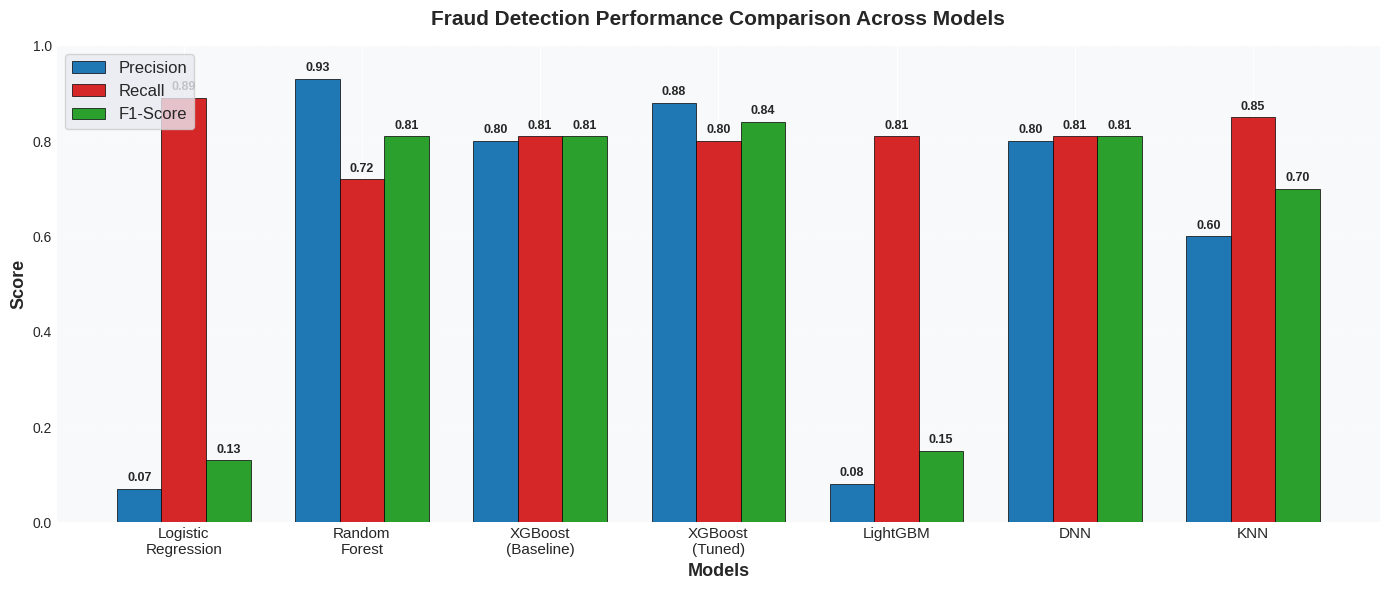

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your results data
models = ['Logistic\nRegression', 'Random\nForest', 'XGBoost\n(Baseline)',
          'XGBoost\n(Tuned)', 'LightGBM', 'DNN', 'KNN']

precision = [0.07, 0.93, 0.80, 0.88, 0.08, 0.80, 0.60]
recall = [0.89, 0.72, 0.81, 0.80, 0.81, 0.81, 0.85]
f1_score = [0.13, 0.81, 0.81, 0.84, 0.15, 0.81, 0.70]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))


bars1 = ax.bar(x - width, precision, width, label='Precision',
               color='#1f77b4', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, recall, width, label='Recall',
               color='#d62728', edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score',
               color='#2ca02c', edgecolor='black', linewidth=0.5)

ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Fraud Detection Performance Comparison Across Models',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=12, frameon=True, shadow=False, loc='upper left')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

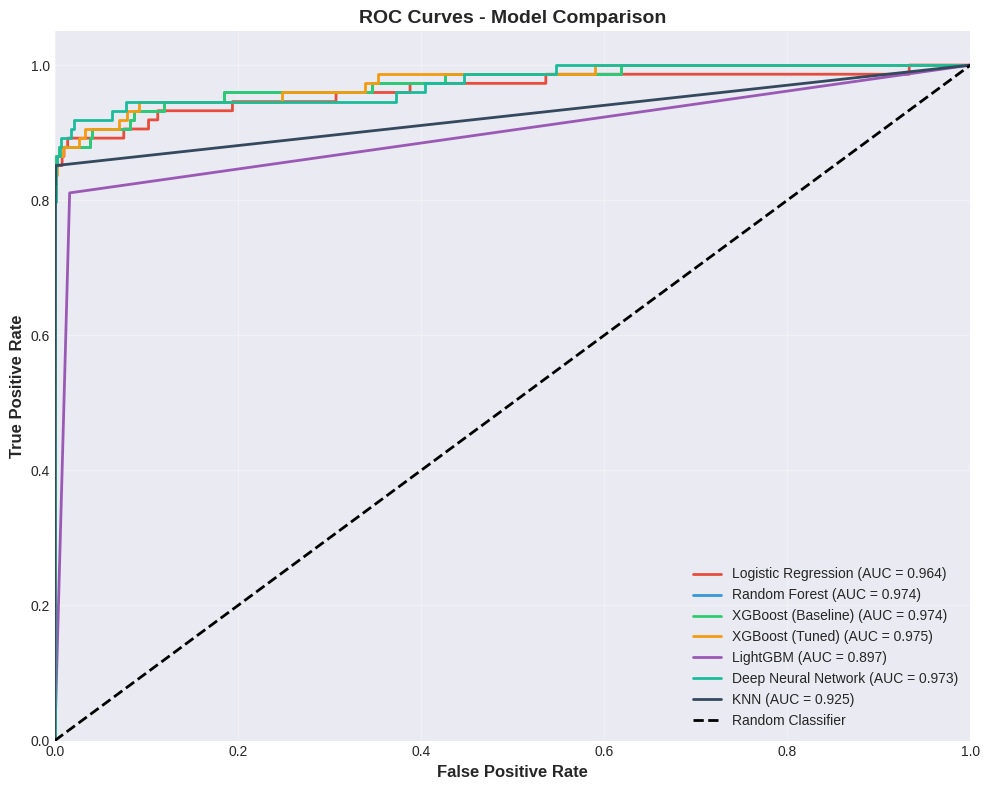

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

models_proba = {
    'Logistic Regression': y_pred_proba,
    'Random Forest': y_proba_xgb,
    'XGBoost (Baseline)': y_proba_xgb,
    'XGBoost (Tuned)': y_proba_tuned,
    'LightGBM': y_pred_lgbm,
    'Deep Neural Network': y_test_proba,
    'KNN': y_proba_knn
}

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#34495e']

for (name, y_proba), color in zip(models_proba.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

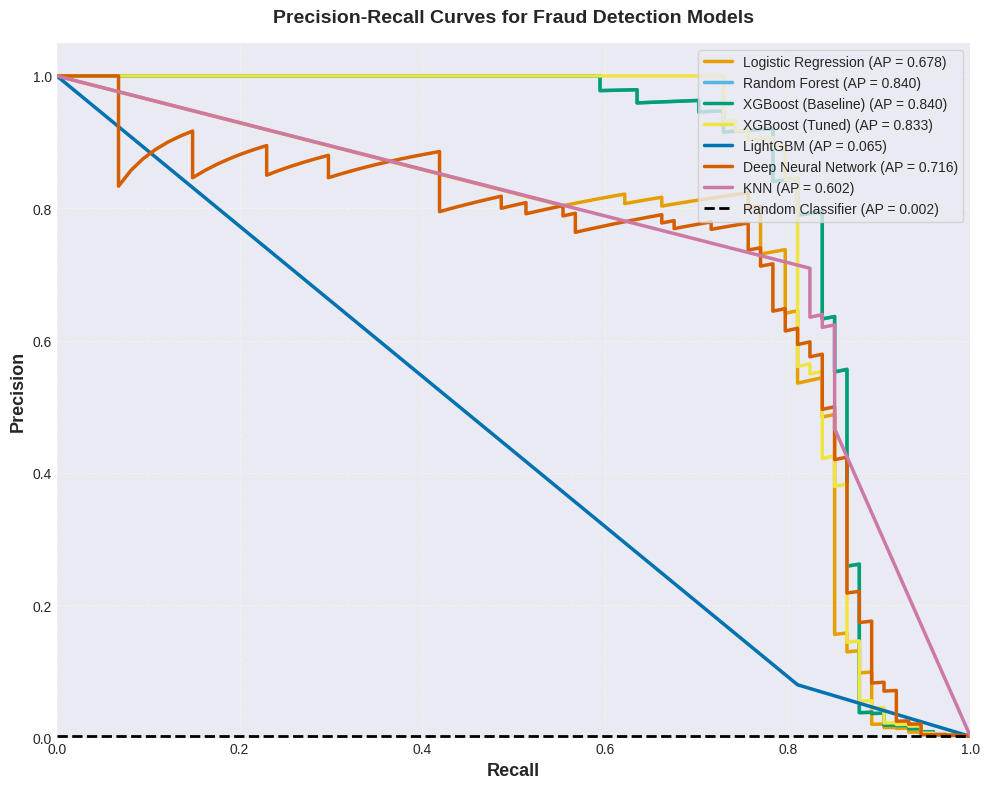


Average Precision (AP) Scores:
Logistic Regression            AP = 0.6776
Random Forest                  AP = 0.8404
XGBoost (Baseline)             AP = 0.8404
XGBoost (Tuned)                AP = 0.8332
LightGBM                       AP = 0.0650
Deep Neural Network            AP = 0.7158
KNN                            AP = 0.6020


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

models_proba = {
    'Logistic Regression': y_pred_proba,
    'Random Forest': y_proba_xgb,
    'XGBoost (Baseline)': y_proba_xgb,
    'XGBoost (Tuned)': y_proba_tuned,
    'LightGBM': y_pred_lgbm,
    'Deep Neural Network': y_test_proba,
    'KNN': y_proba_knn
}


colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']

plt.figure(figsize=(10, 8))

for (name, y_proba), color in zip(models_proba.items(), colors):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, color=color, lw=2.5,
             label=f'{name} (AP = {ap_score:.3f})')

fraud_rate = np.sum(y_test) / len(y_test)
plt.axhline(y=fraud_rate, color='black', linestyle='--', lw=2,
            label=f'Random Classifier (AP = {fraud_rate:.3f})')

plt.xlabel('Recall', fontsize=13, fontweight='bold')
plt.ylabel('Precision', fontsize=13, fontweight='bold')
plt.title('Precision-Recall Curves for Fraud Detection Models',
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="upper right", fontsize=10, frameon=True)
plt.grid(alpha=0.3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\nAverage Precision (AP) Scores:")
print("="*50)
for name, y_proba in models_proba.items():
    ap = average_precision_score(y_test, y_proba)
    print(f"{name:<30} AP = {ap:.4f}")